# Mølmer–Sørensen Gate Simulator
The Molmer-Sorensen Hamiltonian (for one ion) is defined as the sum of the red and blue sideband interactions with symmetric detunning
$$H_{ms}(t) = -i\frac{\eta\Omega}{2}(\sigma_+e^{i\phi_s}-\sigma_-e^{-i\phi_s})(a e^{-i\delta t} + a^{\dagger}e^{i\delta t})$$
However, it is more convinient to use the original form of $\hat{H} = \hat{R}+\hat{B}$, where writes $\delta_r$, $\delta_b$, $\phi_r$, and $\phi_b$ explicitly.
$$-i\frac{\eta}{2}(\Omega_r\sigma_+ae^{-i\delta_r t}e^{i\phi_r}-\Omega_r\sigma_-a^{\dagger}e^{i\delta_r t}e^{-i\phi_r}+ \Omega_b\sigma_+a^{\dagger}e^{-i\delta_b t}e^{i\phi_b} -
\Omega_b\sigma_-ae^{i\delta_b t}e^{-i\phi_b})$$

In [1]:
import qutip as qt
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import datetime
from numpy import linalg
#from numpy import *
import pandas as pd
%matplotlib inline

class MSGateExp:
    def __init__(self, Nmax = 10, eta = 0.1):
        self.Nmax = Nmax
        self.eta = eta
        self.omega_r = np.array([1,1]) * np.pi * 2
        self.omega_b = np.array([1,1]) * np.pi * 2
        self.delta_r = np.array([2,2]) * np.pi * 2
        self.delta_b = np.array([-2,-2]) * np.pi * 2
        self.phi_r = 0
        self.phi_b = 0
        self.Gamma = 0 # Heating rate
        self.nth = 0
        self.output = None
    
    def solve(self, t1):
            
        H0 = -1j*self.eta/2 * \
            self.omega_r[0]*np.exp(1j*self.phi_r) * \
            tensor(sigmap(), qeye(2), destroy(self.Nmax))
        def H0_coeff(t, args):
            return np.exp(-1j*self.delta_r[0]*t)
        
        H1 = 1j*self.eta/2 * \
            self.omega_r[0]*np.exp(-1j*self.phi_r) * \
            tensor(sigmam(), qeye(2), create(self.Nmax))
        def H1_coeff(t, args):
            return np.exp(1j*self.delta_r[0]*t)
        
        H2 = -1j*self.eta/2 * \
            self.omega_b[0]*np.exp(1j*self.phi_b) * \
            tensor(sigmap(), qeye(2), create(self.Nmax))
        def H2_coeff(t, args):
            return np.exp(-1j*self.delta_b[0]*t)

        H3 = 1j*self.eta/2 * \
            self.omega_b[0]*np.exp(-1j*self.phi_b) * \
            tensor(sigmam(), qeye(2), destroy(self.Nmax))
        def H3_coeff(t, args):
            return np.exp(1j*self.delta_b[0]*t)

        H4 = -1j*self.eta/2 * \
            self.omega_r[1]*np.exp(1j*self.phi_r) * \
            tensor(qeye(2), sigmap(), destroy(self.Nmax))
        def H4_coeff(t, args):
            return np.exp(-1j*self.delta_r[1]*t)

        H5 = 1j*self.eta/2 * \
            self.omega_r[1]*np.exp(-1j*self.phi_r) * \
            tensor(qeye(2), sigmam(), create(self.Nmax))
        def H5_coeff(t, args):
            return np.exp(1j*self.delta_r[1]*t)

        H6 = -1j*self.eta/2 * \
            self.omega_b[1]*np.exp(1j*self.phi_b) * \
            tensor(qeye(2), sigmap(), create(self.Nmax))
        def H6_coeff(t, args):
            return np.exp(-1j*self.delta_b[1]*t)

        H7 = 1j*self.eta/2 * \
            self.omega_b[1]*np.exp(-1j*self.phi_b) * \
            tensor(qeye(2), sigmam(), destroy(self.Nmax))
        def H7_coeff(t, args):
            return np.exp(1j*self.delta_b[1]*t)
        
        H = [[H0, H0_coeff], [H1, H1_coeff], [H2, H2_coeff], [H3, H3_coeff],
             [H4, H4_coeff], [H5, H5_coeff], [H6, H6_coeff], [H7, H7_coeff]]
        
        Heye = tensor(qeye(2), qeye(2), qeye(self.Nmax))
        
        c_ops = [tensor(tensor(qeye(2), qeye(2)), np.sqrt(self.Gamma)*destroy(self.Nmax)),
                 tensor(tensor(qeye(2), qeye(2)), np.sqrt(self.Gamma)*create(self.Nmax))]
        
        self.output = mesolve(H, self.s_init, t1, c_ops, [])
        
    def time_scan(self,
                 t_start,
                 t_stop,
                 Nsample, 
                 nth = 0.1,
                 Gamma=1/(2.5e3),
                 omega_r = np.array([1,1]) * np.pi * 2,
                 omega_b = np.array([1,1]) * np.pi * 2,
                 delta_r = np.array([2,2]) * np.pi * 2,
                 delta_b = np.array([-2,-2]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0,
                 ):
        self.nth = nth
        self.Gamma = Gamma
        self.omega_r = omega_r
        self.omega_b = omega_b
        self.delta_r = delta_r
        self.delta_b = delta_b
        self.phi_r = phi_r
        self.phi_b = phi_b
        self.s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(self.Nmax, 0.5))
        
        now = datetime.datetime.now()
        t_list = np.linspace(t_start, t_stop, Nsample)
        self.solve(t_list)
        self.measure(self.output.states, t_list)
        now2 = datetime.datetime.now()
        print(now2-now)
        return self.output.states
        
    
    def StarkShift_scan(self,
                 t_start,
                 t_stop,
                 Nsample,
                 StarkShiftScanList,
                 nth = 0.1,
                 Gamma=0,
                 omega_r = np.array([1,1]) * np.pi * 2,
                 omega_b = np.array([1,1]) * np.pi * 2,
                 delta_r = np.array([2,2]) * np.pi * 2,
                 delta_b = np.array([-2,-2]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0
                       ):
        self.nth = nth
        self.Gamma = Gamma
        self.omega_r = omega_r
        self.omega_b = omega_b
        self.phi_r = phi_r
        self.phi_b = phi_b
        self.s_init = self.s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(self.Nmax, 0.5))
        
        now = datetime.datetime.now()
        t_list = np.linspace(t_start, t_stop, Nsample)
        ScanResult_ee = []
        ScanResult_gg = []
        
        s_ee = tensor(fock(2, 0), fock(2, 0))
        s_gg = tensor(fock(2, 1), fock(2, 1))
        def _measure(state, s_meas):
            state_ptr = state.ptrace([0,1])  
            result = s_meas.dag()*state_ptr*s_meas
            if result.data.data.size:
                return np.real(result.data.data[0])
            else:
                return 0.0    # np.array has same type
            
        for ss in StarkShiftScanList:
            self.delta_r = delta_r + ss
            self.delta_b = delta_b + ss
            
            self.solve(t_list)
            self.measure(self.output.states, t_list)
            ee = _measure(self.output.states[-1], s_ee)
            gg = _measure(self.output.states[-1], s_gg)
            ScanResult_ee.append(ee)
            ScanResult_gg.append(gg)
        now2 = datetime.datetime.now()
        print(now2-now)
        
        plt.plot(StarkShiftScanList, ScanResult_ee, label = '11')
        plt.plot(StarkShiftScanList, ScanResult_gg, label = '00')
        plt.xlabel('Stark Shift scan')
        plt.ylabel('Probability')
        plt.legend()
        
    def detuning_scan(self,
                      delta_start,
                      delta_stop,
                      Nsample,
                      t1=np.linspace(0, 0.5, 2),
                      t2=np.linspace(0, 0.5, 2),
                      nth=0.1,
                      Gamma=1/(2.5e3),
                      omega_r=np.array([1, 1])*np.pi*2,
                      omega_b=np.array([1, 1])*np.pi*2,
                      delta_r=np.array([1, 1])*np.pi*2,
                      delta_b=np.array([-1, -1])*np.pi*2,
                      phi_r=0,
                      phi_b=0
                     ):
        self.nth = nth
        self.Gamma = Gamma
        self.omega_r = omega_r
        self.omega_b = omega_b
        self.delta_r = delta_r
        self.delta_b = delta_b
        self.phi_r = phi_r
        self.phi_b = phi_b
        delta_list = np.linspace(delta_start, delta_stop, Nsample)
        states = []
        for delta in delta_list:
            self.delta_r = delta*np.array([1, 1])*np.pi*2
            self.delta_b = delta*np.array([-1, -1])*np.pi*2
            self.s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(self.Nmax, 0.5))
            self.solve(t1)
            states.append(self.output.states[-1])
        #states = np.array(states)
        self.measure(states, delta_list)
        
    def phase_space_scan(self,
                        t_start,
                        t_stop,
                        Nsample,
                        nth = 0,
                        Gamma = 0.1,
                        omega_r = np.array([1,1]) * np.pi * 2,
                        omega_b = np.array([1,1]) * np.pi * 2,
                        delta_r = np.array([2,2]) * np.pi * 2,
                        delta_b = np.array([-2,-2]) * np.pi * 2,
                        phi_r = 0,
                        phi_b = 0,
                        s_init = None):
        self.nth = nth
        self.Gamma = Gamma
        self.omega_r = omega_r
        self.omega_b = omega_b
        self.delta_r = delta_r
        self.delta_b = delta_b
        self.phi_r = phi_r
        self.phi_b = phi_b
        eigen_states = (tensor(sigmap(), qeye(2)) - tensor(sigmam(), qeye(2)) +
                        tensor(qeye(2), sigmap()) - tensor(qeye(2), sigmam())).eigenstates()
        if not s_init:
            self.s_init = tensor(eigen_states[1][3], fock(self.Nmax, self.nth))
        else:
            self.s_init = s_init
        t_list = np.linspace(t_start, t_stop, Nsample)
        self.solve(t_list)  
        #states = np.array(self.output.states)
        states = self.output.states
        n_phase_plot_x = np.zeros(Nsample)
        n_phase_plot_p = np.zeros(Nsample)
        for i in range(len(states)):
            n_phase_plot_x[i] = self.phase_space_x(states[i])
            n_phase_plot_p[i] = self.phase_space_p(states[i])
        '''
        v_phase_plot_x = np.vectorize(self.phase_space_x)
        v_phase_plot_p = np.vectorize(self.phase_space_p)
        self.plot_ps(v_phase_plot_x(states), v_phase_plot_p(states))
        '''
        self.plot_ps(n_phase_plot_x, n_phase_plot_p)

    def phase_space_x(self, state):
        x = 1/np.sqrt(2)*(destroy(self.Nmax)+create(self.Nmax))
        state_ptr = state.ptrace([2])
        x_expect = np.real((state_ptr*x).tr())
        return x_expect

    def phase_space_p(self, state):
        p = 1j/np.sqrt(2)*(create(self.Nmax)-destroy(self.Nmax))
        state_ptr = state.ptrace([2])
        p_expect = np.real((state_ptr*p).tr())
        return p_expect
    
    
    
    def plot_ps(self, x_array, p_array):
        fig, ax = plt.subplots()
        ax.plot(p_array, x_array)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        ax.grid()
        ax.yaxis.set_ticks(np.arange(-2, 2.5, 0.5))
        ax.xaxis.set_ticks(np.arange(-2, 2.5, 0.5))
        plt.gca().set_aspect('equal', adjustable='box')
        ax.set_xlabel('<x>')
        ax.set_ylabel('<p>')
        plt.show()
        
    def measure(self, states, x_axis):
        # states: np.array of dm includes two ions and phonons
        s_ee = tensor(fock(2, 0), fock(2, 0))
        s_gg = tensor(fock(2, 1), fock(2, 1))
        s_eg = (tensor(fock(2, 0), fock(2, 1)) +
                tensor(fock(2, 1), fock(2, 0))).unit()
        
        def _measure(state, s_meas):
            state_ptr = state.ptrace([0,1])  
            result = s_meas.dag()*state_ptr*s_meas
            if result.data.data.size:
                return np.real(result.data.data[0])
            else:
                return 0.0    # np.array has same type
         
        ee = np.zeros(len(states))
        gg = np.zeros(len(states))
        eg = np.zeros(len(states))
        for i in range(len(states)):
            ee[i] = _measure(states[i], s_ee)
            gg[i] = _measure(states[i], s_gg)
            eg[i] = _measure(states[i], s_eg)
    
        fig, ax = plt.subplots()
        ax.plot(x_axis, ee)
        ax.plot(x_axis, gg)
        ax.plot(x_axis, eg)
        # ax.set_xlabel()
        ax.set_ylabel('Probability')
        ax.legend(('11', '00', '01+10'))
        plt.show()
      
        
        # Plot single ion states:
        '''
        s_e = fock(2, 0)
        s_g = fock(2, 1)
        def _measureSingle0(state, s_meas):
            state_ptr = state.ptrace([0])  
            result = s_meas.dag()*state_ptr*s_meas
            if result.data.data.size:
                return np.real(result.data.data[0])
            else:
                return 0.0    # np.array has same type
         
        e0 = np.zeros(len(states))
        g0 = np.zeros(len(states))
        for i in range(len(states)):
            e0[i] = _measureSingle0(states[i], s_e)
            g0[i] = _measureSingle0(states[i], s_g)
            
        fig, ax = plt.subplots()
        ax.plot(x_axis, e0)
        ax.plot(x_axis, g0)
        # ax.set_xlabel()
        ax.set_ylabel('Probability of ion0')
        ax.legend(('0', '1'))
        plt.show()
        
        def _measureSingle1(state, s_meas):
            state_ptr = state.ptrace([1])  
            result = s_meas.dag()*state_ptr*s_meas
            if result.data.data.size:
                return np.real(result.data.data[0])
            else:
                return 0.0    # np.array has same type
         
        e1 = np.zeros(len(states))
        g1 = np.zeros(len(states))
        for i in range(len(states)):
            e1[i] = _measureSingle1(states[i], s_e)
            g1[i] = _measureSingle1(states[i], s_g)
            
        fig, ax = plt.subplots()
        ax.plot(x_axis, e1)
        ax.plot(x_axis, g1)
        # ax.set_xlabel()
        ax.set_ylabel('Probability of ion1')
        ax.legend(('0', '1'))
        plt.show()
  '''

Quick gates $\delta_0 = 2 \eta \Omega$, $t_g = 2\pi/\delta_0$

delta =  25000.0
t_gate =  4e-05


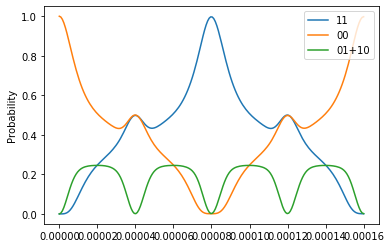

0:00:00.622107


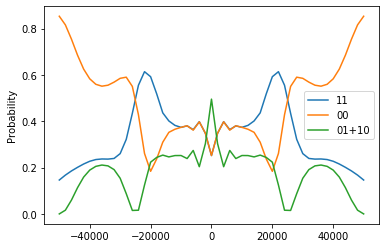

In [7]:
omega = 1.25e5
eta = 0.1
delta = 2*eta*omega
print('delta = ',delta)
tg = 1/delta # pi/2 gate time
tw = 0
print('t_gate = ', tg)
exp1 = MSGateExp(Nmax=10,eta = eta)
# exp1.phase_space_scan(0,1,200)
exp1.time_scan(0, 4*tg, 200, Gamma=0,
               omega_r = np.array([omega,omega]) * np.pi * 2,
               omega_b = np.array([omega,omega]) * np.pi * 2,
               delta_r = np.array([delta,delta]) * np.pi * 2,
               delta_b = np.array([-delta,-delta]) * np.pi * 2)
# exp1.phase_space_scan(0,1,200)
exp1.detuning_scan(-2*delta,2*delta,51,t1=np.linspace(0, tg, 2),t2=np.linspace(0, tw, 2),Gamma = 0,
                   omega_r = np.array([omega, omega])*np.pi*2,
                   omega_b = np.array([omega, omega])*np.pi*2)

### Three gates

delta =  25000.0
t_gate =  4e-05


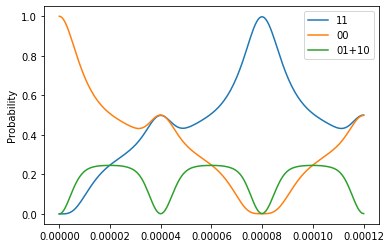

0:00:00.585285


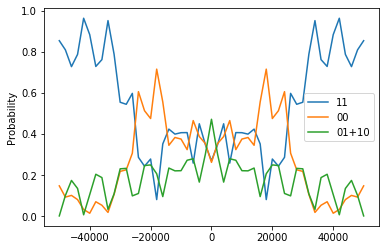

In [8]:
omega = 1.25e5
eta = 0.1
delta = 2*eta*omega
print('delta = ',delta)
tg = 1/delta
tw = 0
print('t_gate = ', tg)
exp1 = MSGateExp(Nmax=10,eta = eta)
# exp1.phase_space_scan(0,1,200)
exp1.time_scan(0, 3*tg, 200, Gamma=0,
               omega_r = np.array([omega,omega]) * np.pi * 2,
               omega_b = np.array([omega,omega]) * np.pi * 2,
               delta_r = np.array([delta,delta]) * np.pi * 2,
               delta_b = np.array([-delta,-delta]) * np.pi * 2)
# exp1.phase_space_scan(0,1,200)
exp1.detuning_scan(-2*delta,2*delta,51,t1=np.linspace(0, tg*3, 2),t2=np.linspace(0, tw, 2),Gamma = 0,
                   omega_r = np.array([omega, omega])*np.pi*2,
                   omega_b = np.array([omega, omega])*np.pi*2)

### Five gates

delta =  25000.0
t_gate =  4e-05


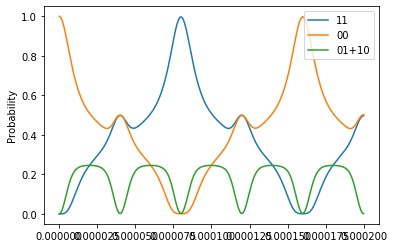

0:00:00.637510


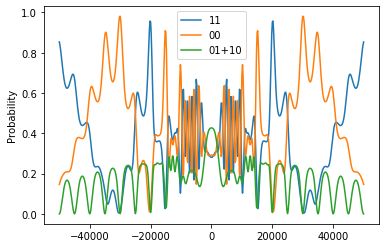

In [10]:
omega = 1.25e5
eta = 0.1
delta = 2*eta*omega
print('delta = ',delta)
tg = 1/delta
tw = 0
print('t_gate = ', tg)
exp1 = MSGateExp(Nmax=10,eta = eta)
# exp1.phase_space_scan(0,1,200)
exp1.time_scan(0, 5*tg, 200, Gamma=0,
               omega_r = np.array([omega,omega]) * np.pi * 2,
               omega_b = np.array([omega,omega]) * np.pi * 2,
               delta_r = np.array([delta,delta]) * np.pi * 2,
               delta_b = np.array([-delta,-delta]) * np.pi * 2)
# exp1.phase_space_scan(0,1,200)
exp1.detuning_scan(-2*delta,2*delta,501,t1=np.linspace(0, tg*5, 2),t2=np.linspace(0, tw, 2),Gamma = 0,
                   omega_r = np.array([omega, omega])*np.pi*2,
                   omega_b = np.array([omega, omega])*np.pi*2)

# Parity Scan

In [3]:
def ParityScan(ThetaList, rho):
    XX = tensor(sigmax(),sigmax())
    XY = tensor(sigmax(),sigmay())
    YX = tensor(sigmay(),sigmax())
    YY = tensor(sigmay(),sigmay())
    results = []
    for theta in ThetaList:
        meas = np.cos(theta)**2*YY-np.sin(theta)*np.cos(theta)*(YX+XY)+np.sin(theta)**2*XX
        results.append(np.real((rho*meas).tr()))
    plt.plot(ThetaList, results)
    plt.xlabel('Phase Scan')
    plt.ylabel('Parity')
    
    '''print('Max parity = ', max(results))
    print('Min parity = ', min(results))
    print('Parity contrast = ', (max(results)-min(results))/2)'''
    return [max(results), min(results), (max(results)-min(results))/2]
    

def Population(rho):
    s_ee = tensor(fock(2, 0), fock(2, 0))
    s_gg = tensor(fock(2, 1), fock(2, 1))
    s_eg = (tensor(fock(2, 0), fock(2, 1)) +
            tensor(fock(2, 1), fock(2, 0))).unit()

    def _measure(state, s_meas):
        state_ptr = state.ptrace([0,1])  
        result = s_meas.dag()*state_ptr*s_meas
        if result.data.data.size:
            return np.real(result.data.data[0])
        else:
            return 0.0    # np.array has same type
    
    ee = _measure(rho, s_ee)
    gg = _measure(rho, s_gg)
    eg = _measure(rho, s_eg)
    
    print('Prob_11 = ', ee)
    print('Prob_00 = ', gg)
    print('Prob_01+10 = ', eg)

## Ideal case

delta =  25000.0
t_gate =  4e-05


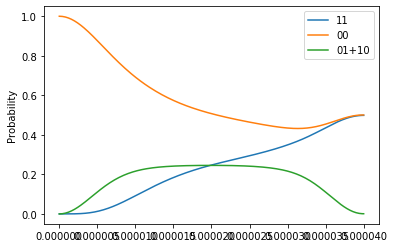

0:00:00.533878
Prob_11 =  0.49859747106299007
Prob_00 =  0.5004713911571109
Prob_01+10 =  0.0009311377798986452


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[4.98597471e-01-2.09294382e-19j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 4.65568890e-04-4.99048310e-01j]
 [0.00000000e+00+0.00000000e+00j 4.65568890e-04+2.64316906e-17j
  4.65568890e-04-3.66563083e-17j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 4.65568890e-04+3.67695655e-17j
  4.65568890e-04-3.03327122e-17j 0.00000000e+00+0.00000000e+00j]
 [4.65568890e-04+4.99048310e-01j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 5.00471391e-01+5.11638362e-18j]]

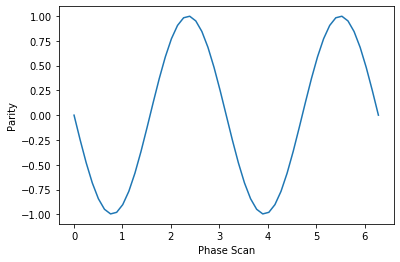

In [4]:
omega = 1.25e5
eta = 0.1
delta = 2*eta*omega
print('delta = ',delta)
tg = 1/delta
tw = 0
print('t_gate = ', tg)
exp1 = MSGateExp(Nmax=10,eta = eta)
states = exp1.time_scan(0, tg, 200, Gamma=0,
               omega_r = np.array([omega,omega]) * np.pi * 2,
               omega_b = np.array([omega,omega]) * np.pi * 2,
               delta_r = np.array([delta,delta]) * np.pi * 2,
               delta_b = np.array([-delta,-delta]) * np.pi * 2)

rho = states[-1].ptrace([0,1])
ThetaList = np.linspace(0,2*np.pi,51)
ParityScan(ThetaList, rho)
Population(states[-1])
rho

### No gate, parity scan only

delta =  25000.0
t_gate =  4e-05


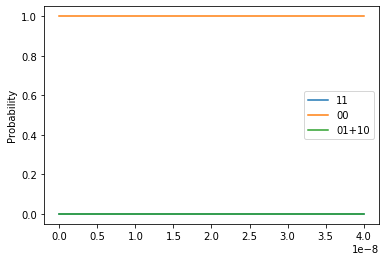

0:00:00.526191
Prob_11 =  1.4846653970097747e-11
Prob_00 =  0.9999901337697906
Prob_01+10 =  9.866215362524984e-06


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1.48466540e-11-5.27298045e-31j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 4.93310768e-06-5.16774618e-09j]
 [0.00000000e+00+0.00000000e+00j 4.93310768e-06+5.05333848e-31j
  4.93310768e-06+1.17721678e-24j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 4.93310768e-06-1.17721678e-24j
  4.93310768e-06+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [4.93310768e-06+5.16774618e-09j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 9.99990134e-01+0.00000000e+00j]]

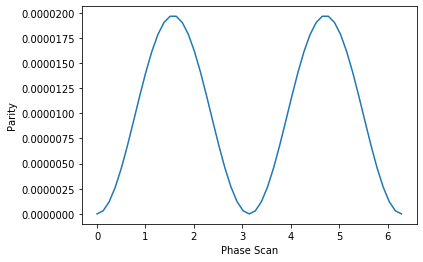

In [13]:
omega = 1.25e5
eta = 0.1
delta = 2*eta*omega
print('delta = ',delta)
tg = 1/delta
tw = 0
print('t_gate = ', tg)
exp1 = MSGateExp(Nmax=10,eta = eta)
states = exp1.time_scan(0, tg, 200, Gamma=0,
               omega_r = np.array([omega,omega]) * np.pi * 2,
               omega_b = np.array([omega,omega]) * np.pi * 2,
               delta_r = np.array([delta,delta]) * np.pi * 2,
               delta_b = np.array([-delta,-delta]) * np.pi * 2)

rho = states[-1].ptrace([0,1])
ThetaList = np.linspace(0,2*np.pi,51)
ParityScan(ThetaList, rho)
Population(states[-1])
rho

### three gates

delta =  25000.0
t_gate =  4e-05


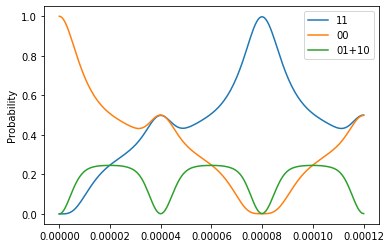

0:00:00.597741
Prob_11 =  0.5000850889922833
Prob_00 =  0.49829027839761003
Prob_01+10 =  0.0016246326101055104


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.50008509-8.77810198e-17j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.00081232+4.98373350e-01j]
 [0.        +0.00000000e+00j 0.00081232+5.08483668e-18j
  0.00081232+1.25240837e-17j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.00081232+3.30787117e-17j
  0.00081232+3.48111610e-17j 0.        +0.00000000e+00j]
 [0.00081232-4.98373350e-01j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.49829028+4.80239820e-17j]]

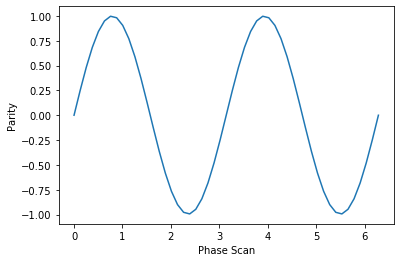

In [92]:
omega = 1.25e5
eta = 0.1
delta = 2*eta*omega
print('delta = ',delta)
tg = 1/delta
tw = 0
print('t_gate = ', tg)
exp1 = MSGateExp(Nmax=10,eta = eta)
states = exp1.time_scan(0, 3*tg, 200, Gamma=0,
               omega_r = np.array([omega,omega]) * np.pi * 2,
               omega_b = np.array([omega,omega]) * np.pi * 2,
               delta_r = np.array([delta,delta]) * np.pi * 2,
               delta_b = np.array([-delta,-delta]) * np.pi * 2)

rho = states[-1].ptrace([0,1])
ThetaList = np.linspace(0,2*np.pi,51)
ParityScan(ThetaList, rho)
Population(states[-1])
rho

## Phase unbalance

delta =  25000.0
t_gate =  4e-05


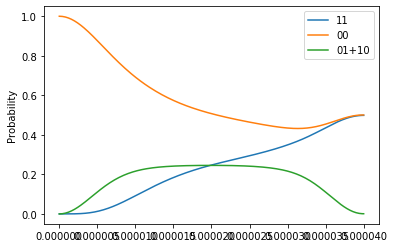

0:00:00.537748
Max parity =  0.9945105410399089
Min parity =  -0.9967022287253102
Parity contrast =  0.9956063848826096
Prob_11 =  0.4985974710630002
Prob_00 =  0.500471391157108
Prob_01+10 =  0.0009311377798917264


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[4.98597471e-01+1.41181891e-17j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 3.53209651e-01-3.52551237e-01j]
 [0.00000000e+00+0.00000000e+00j 4.65568890e-04-1.14097942e-17j
  4.65568890e-04+1.47309643e-17j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 4.65568890e-04+1.57063950e-17j
  4.65568890e-04+3.85885149e-17j 0.00000000e+00+0.00000000e+00j]
 [3.53209651e-01+3.52551237e-01j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 5.00471391e-01-4.36192653e-17j]]

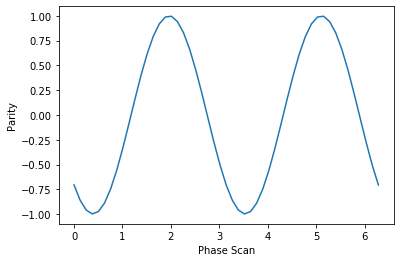

In [63]:
omega = 1.25e5
eta = 0.1
delta = 2*eta*omega
print('delta = ',delta)
tg = 1/delta
tw = 0
print('t_gate = ', tg)
exp1 = MSGateExp(Nmax=10,eta = eta)
states = exp1.time_scan(0, tg, 200, Gamma=0,
               omega_r = np.array([omega,omega]) * np.pi * 2,
               omega_b = np.array([omega,omega]) * np.pi * 2,
               delta_r = np.array([delta,delta]) * np.pi * 2,
               delta_b = np.array([-delta,-delta]) * np.pi * 2,
               phi_r = 0,
               phi_b = np.pi/4)

rho = states[-1].ptrace([0,1])
ThetaList = np.linspace(0,2*np.pi,51)
ParityScan(ThetaList, rho)
Population(states[-1])
rho

## Wrong Stark shift

delta =  25000.0
t_gate =  4e-05


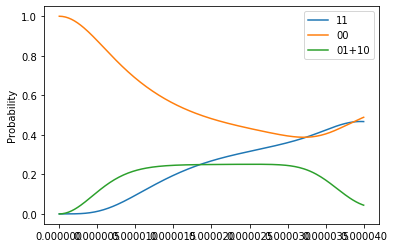

0:00:00.523313
Max parity =  0.9709939915986491
Min parity =  -0.8798597564647023
Parity contrast =  0.9254268740316757
Prob_11 =  0.4671216728330577
Prob_00 =  0.4887054232831832
Prob_01+10 =  0.04417290388375884


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.46712167+5.30822859e-17j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j -0.350155  -3.04082119e-01j]
 [ 0.        +0.00000000e+00j  0.02208645-1.99880919e-17j
   0.02208645+3.08490507e-17j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.02208645-4.59067912e-17j
   0.02208645+3.43637451e-18j  0.        +0.00000000e+00j]
 [-0.350155  +3.04082119e-01j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.48870542-3.79401748e-17j]]

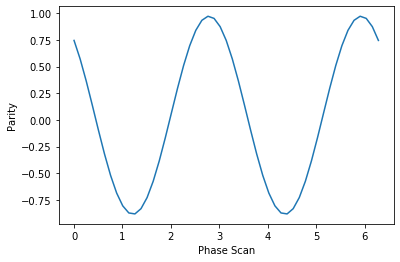

In [71]:
omega = 1.25e5
eta = 0.1
delta = 2*eta*omega
print('delta = ',delta)
tg = 1/delta
tw = 0
print('t_gate = ', tg)
exp1 = MSGateExp(Nmax=10,eta = eta)
states = exp1.time_scan(0, tg, 200, Gamma=0,
               omega_r = np.array([omega,omega]) * np.pi * 2,
               omega_b = np.array([omega,omega]) * np.pi * 2,
               delta_r = np.array([1.1*delta,1.1*delta]) * np.pi * 2,
               delta_b = np.array([-0.9*delta,-0.9*delta]) * np.pi * 2,
               phi_r = 0,
               phi_b = 0)

rho = states[-1].ptrace([0,1])
ThetaList = np.linspace(0,2*np.pi,51)
ParityScan(ThetaList, rho)
Population(states[-1])
rho

delta =  25000.0
t_gate =  4e-05


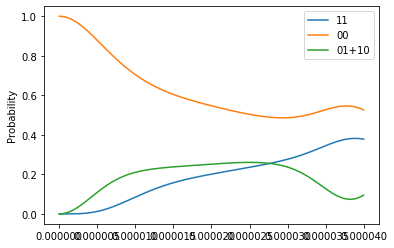

0:00:00.523791


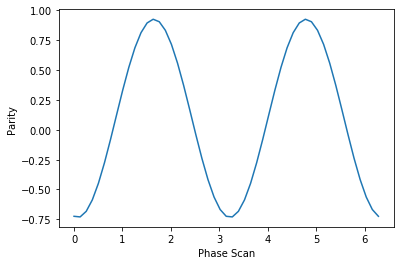

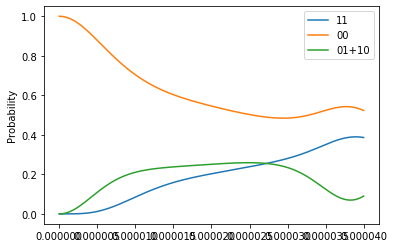

0:00:00.597501


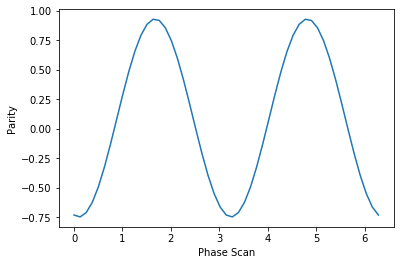

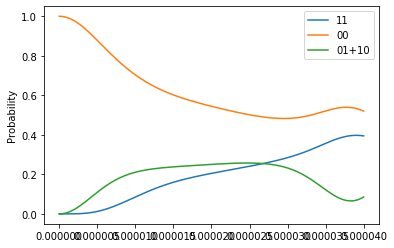

0:00:00.612963


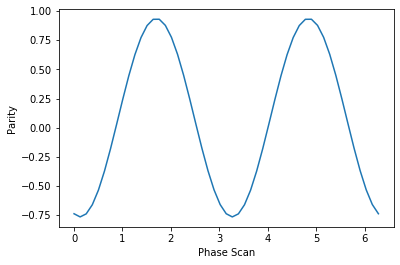

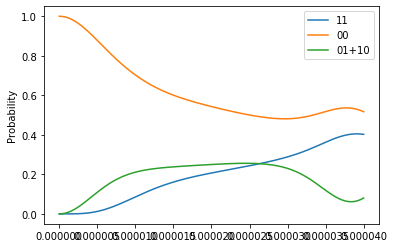

0:00:00.604628


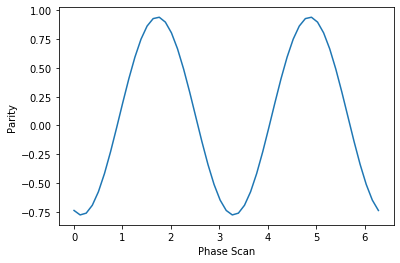

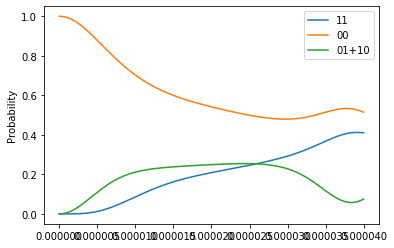

0:00:00.571755


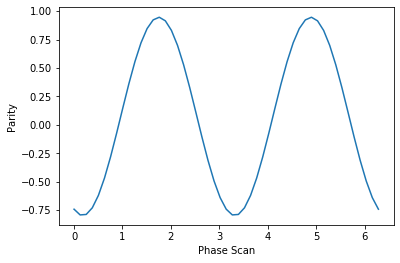

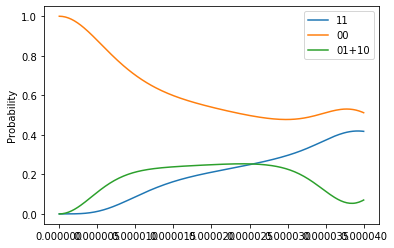

0:00:00.581054


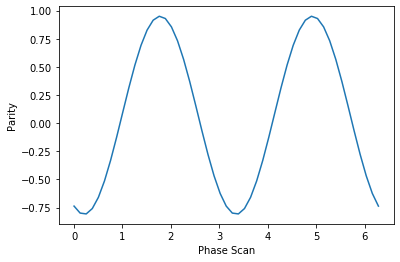

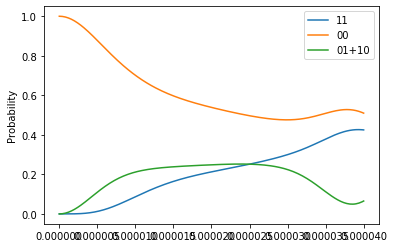

0:00:00.625293


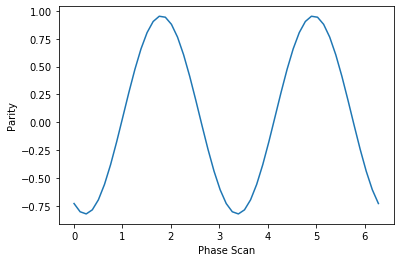

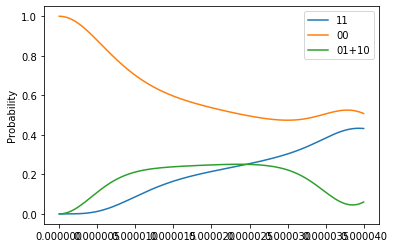

0:00:00.567837


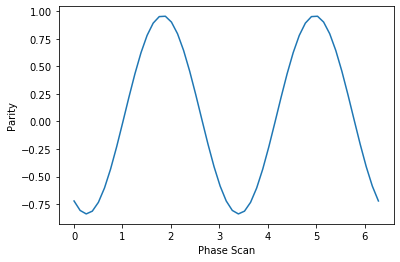

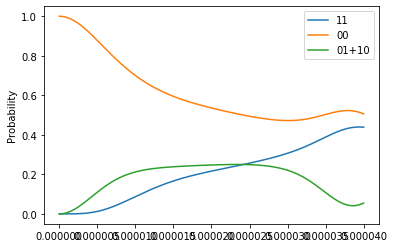

0:00:00.572442


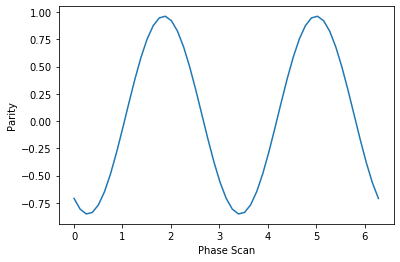

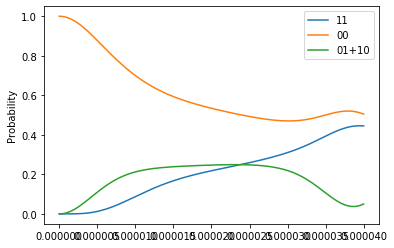

0:00:00.568281


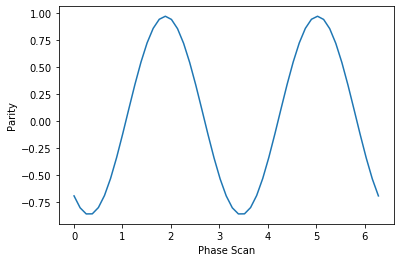

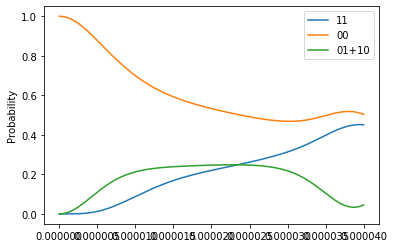

0:00:00.569173


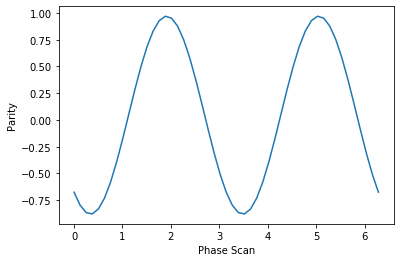

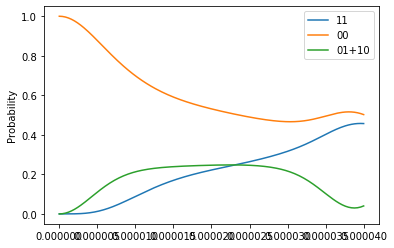

0:00:00.564389


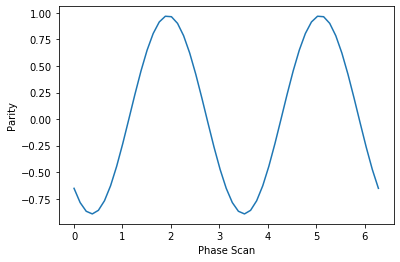

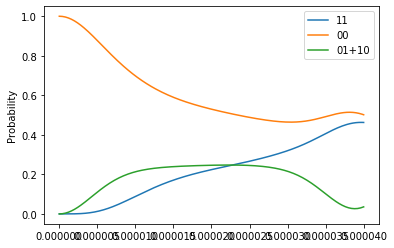

0:00:00.573141


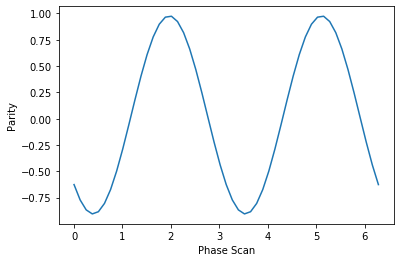

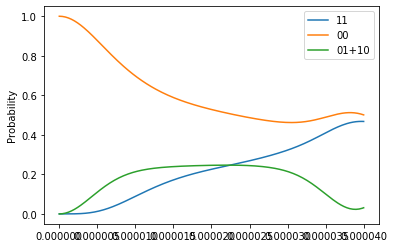

0:00:00.569276


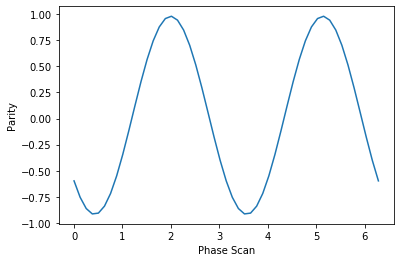

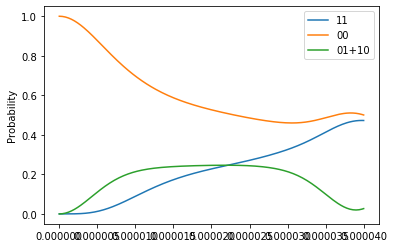

0:00:00.568119


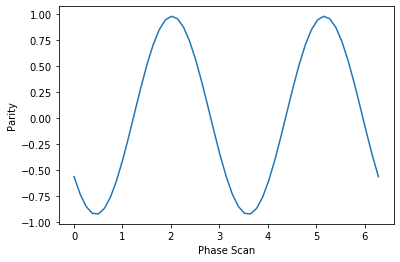

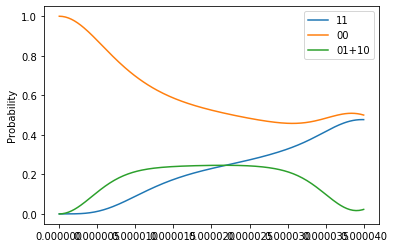

0:00:00.582941


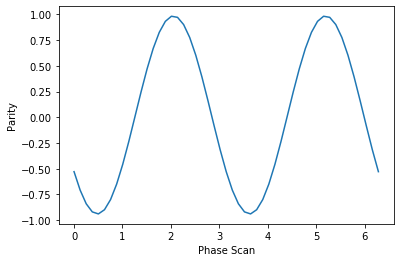

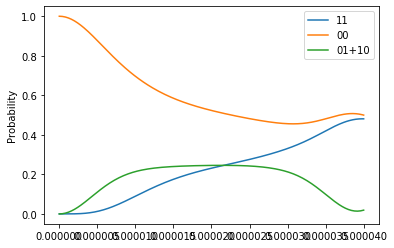

0:00:00.587224


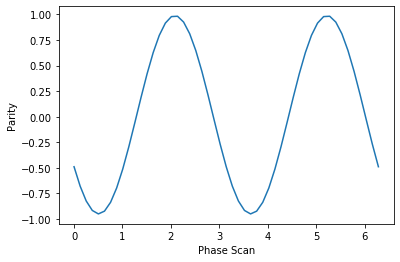

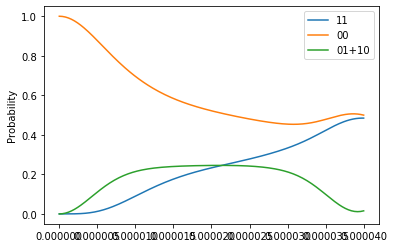

0:00:00.636765


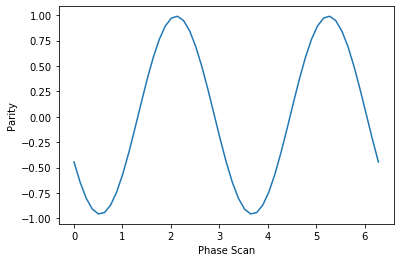

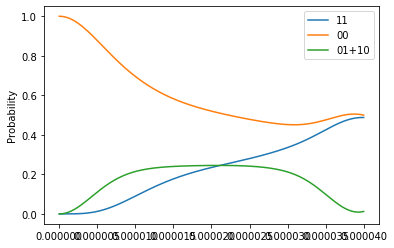

0:00:00.564154


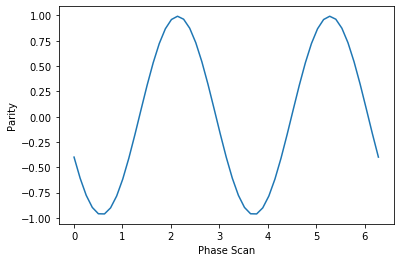

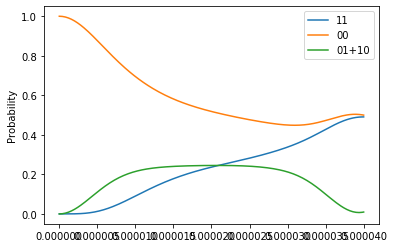

0:00:00.586786


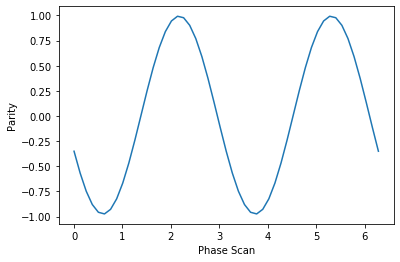

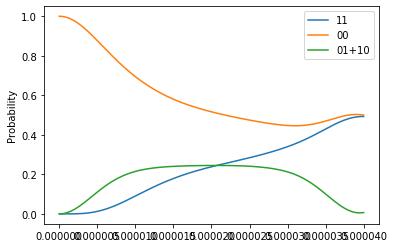

0:00:00.571325


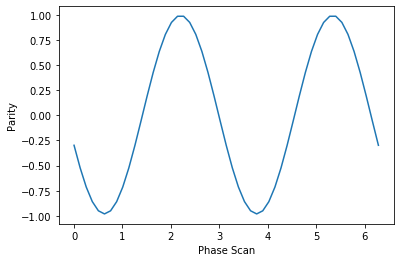

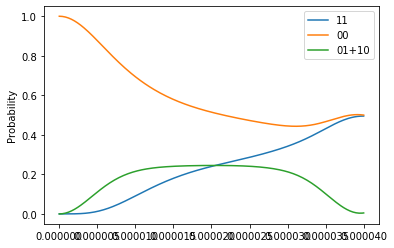

0:00:00.595702


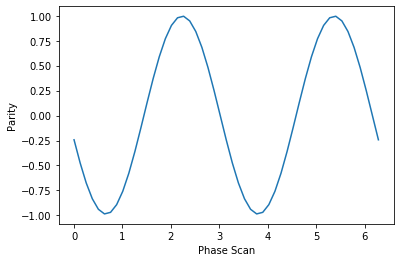

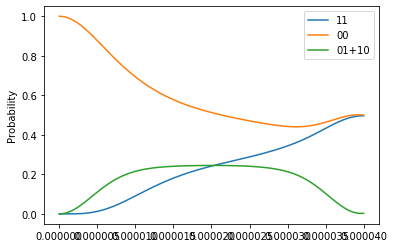

0:00:00.571309


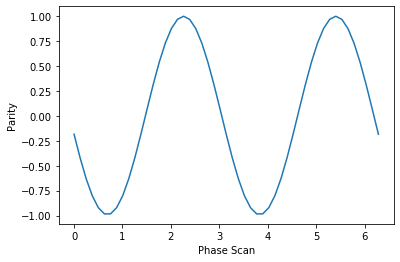

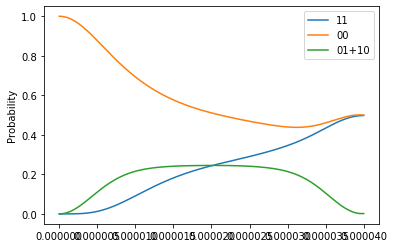

0:00:00.578355


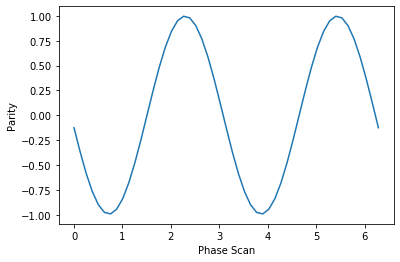

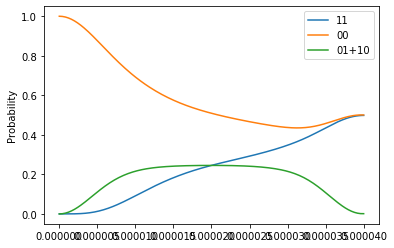

0:00:00.571667


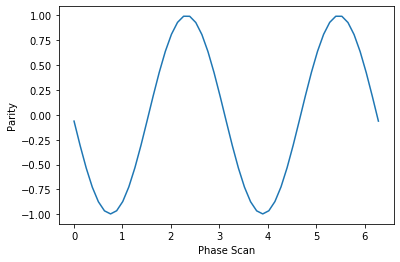

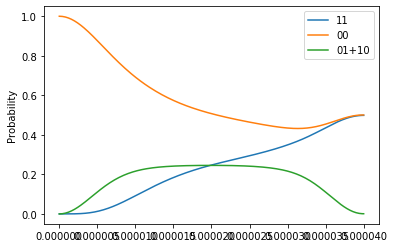

0:00:00.579144


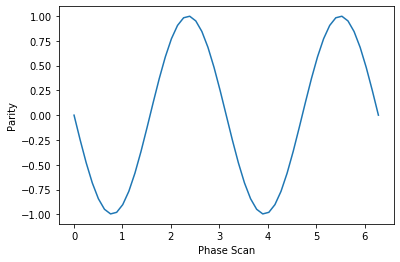

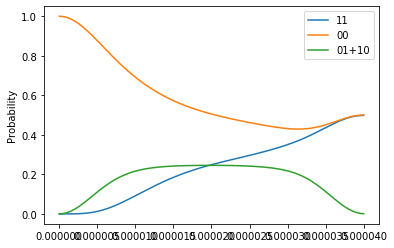

0:00:00.577711


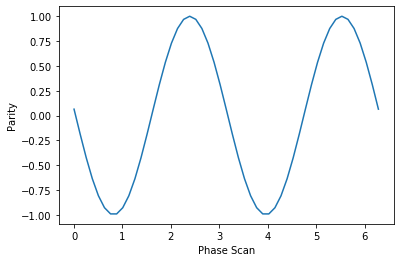

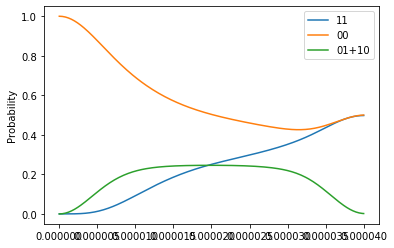

0:00:00.578306


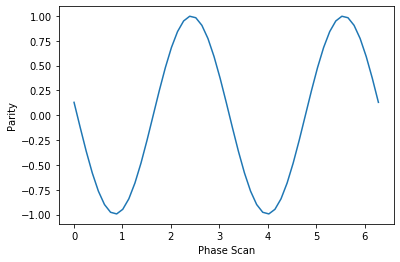

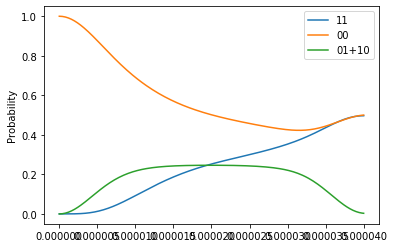

0:00:00.624952


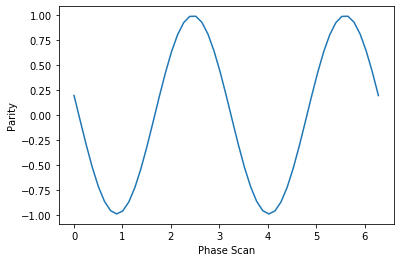

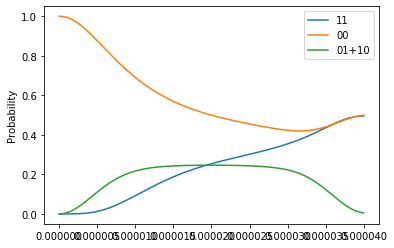

0:00:00.571078


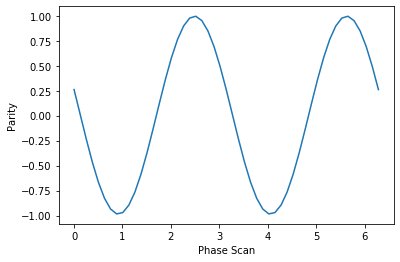

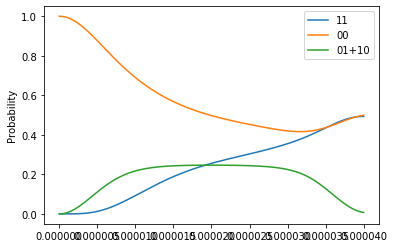

0:00:00.603623


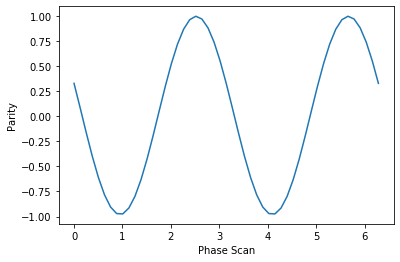

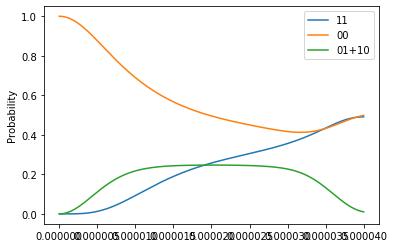

0:00:00.605673


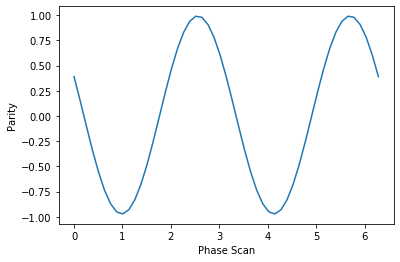

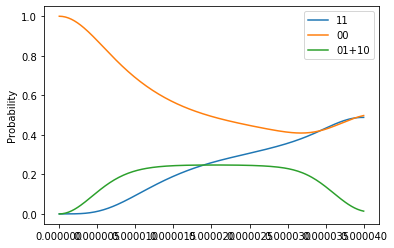

0:00:00.609310


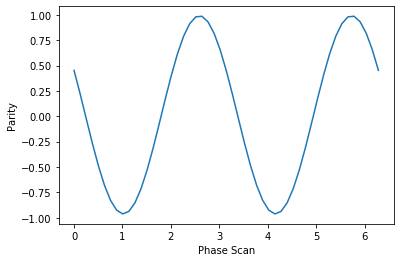

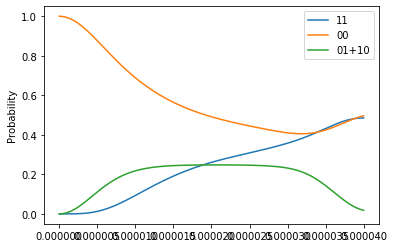

0:00:00.590825


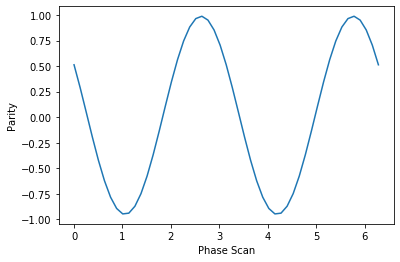

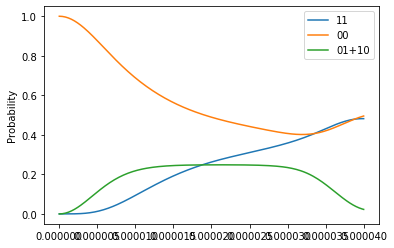

0:00:00.576145


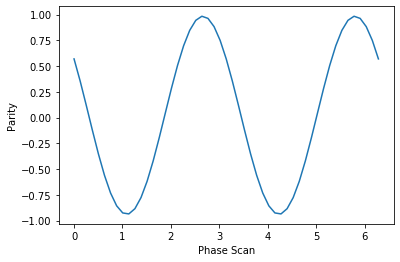

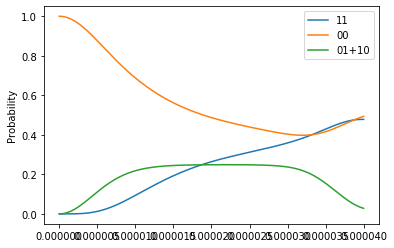

0:00:00.603552


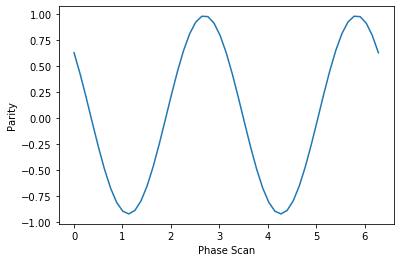

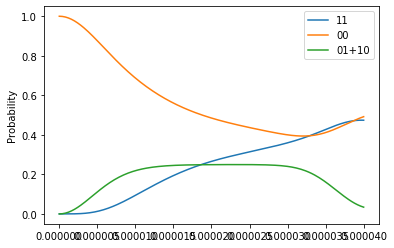

0:00:00.612673


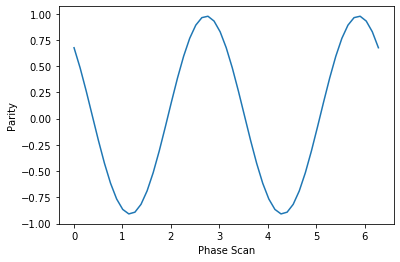

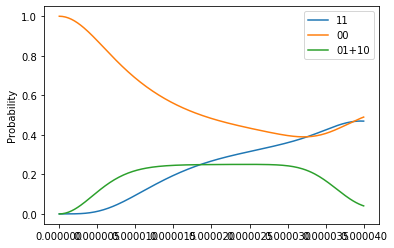

0:00:00.602117


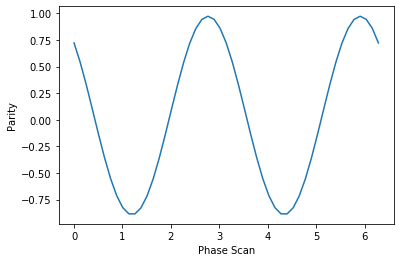

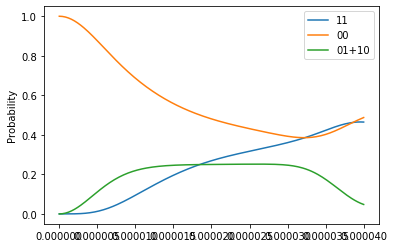

0:00:00.585515


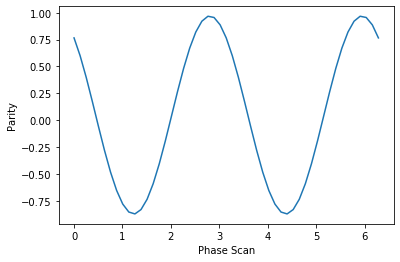

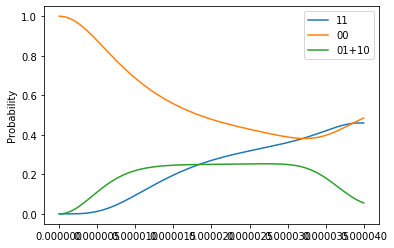

0:00:00.672625


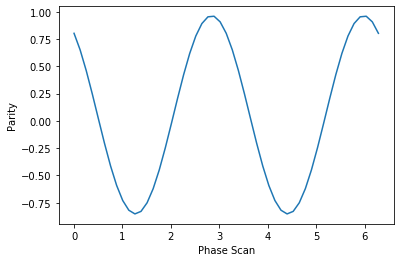

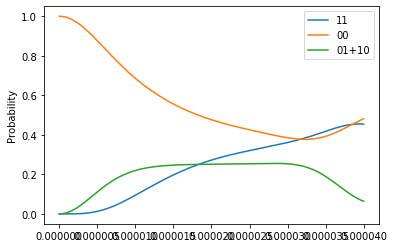

0:00:00.606741


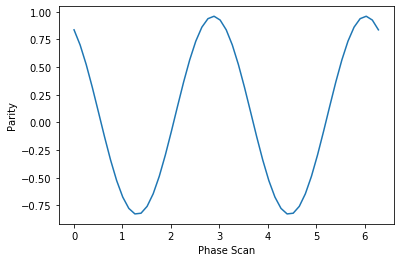

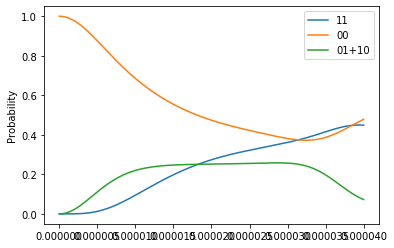

0:00:00.612012


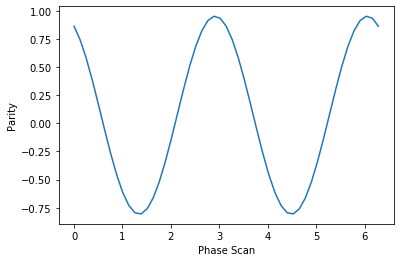

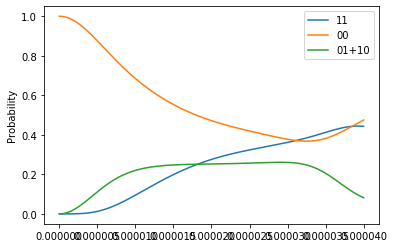

0:00:00.620469


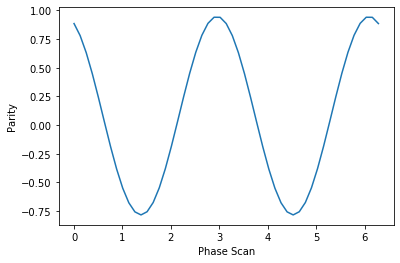

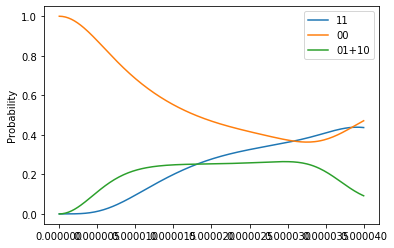

0:00:00.621748


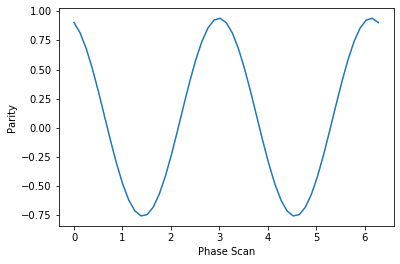

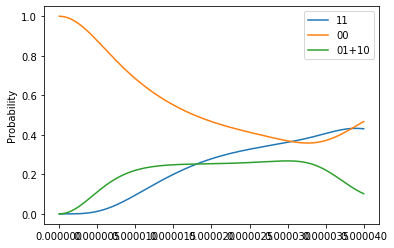

0:00:00.623261


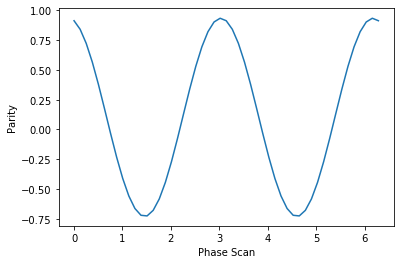

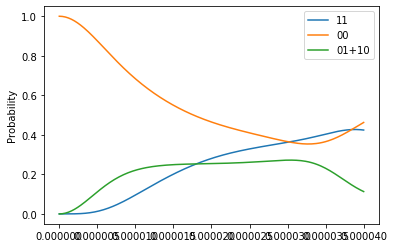

0:00:00.623824


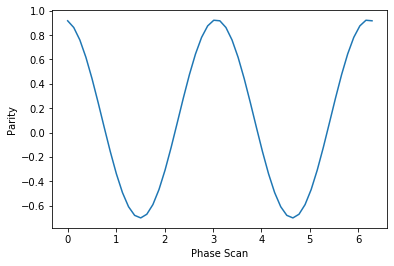

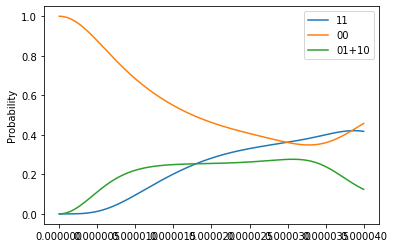

0:00:00.590244


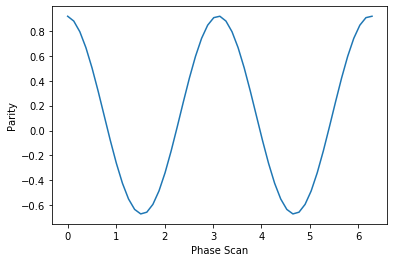

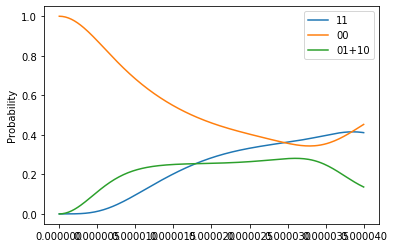

0:00:00.598238


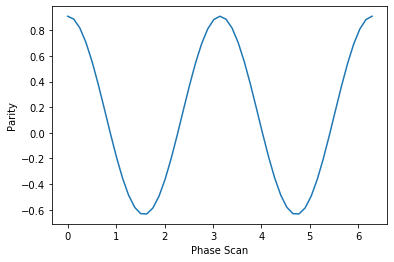

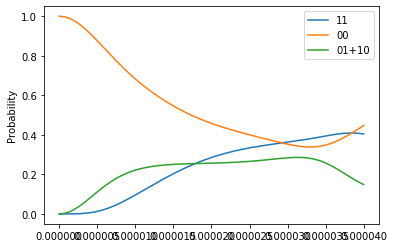

0:00:00.587734


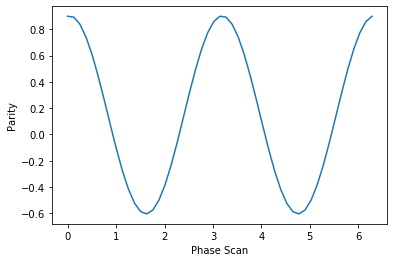

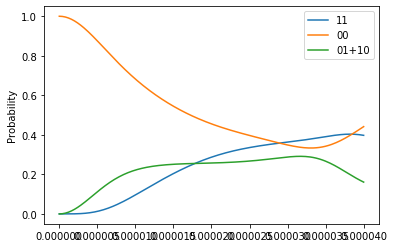

0:00:00.599588


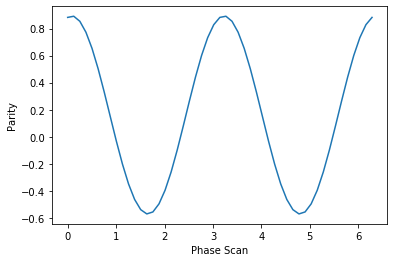

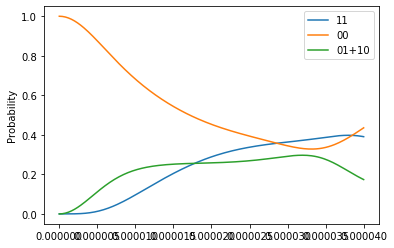

0:00:00.696172


[0.929448251133923, -0.7650293816129584, 0.8472388163734408]

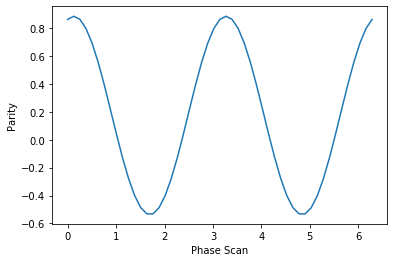

In [73]:
StarkShiftList = np.linspace(-0.2,0.2,51)

omega = 1.25e5
eta = 0.1
delta = 2*eta*omega
print('delta = ',delta)
tg = 1/delta
tw = 0
print('t_gate = ', tg)

exp1 = MSGateExp(Nmax=10,eta = eta)
res = []
for ss in StarkShiftList:
    states = exp1.time_scan(0, tg, 200, Gamma=0,
               omega_r = np.array([omega,omega]) * np.pi * 2,
               omega_b = np.array([omega,omega]) * np.pi * 2,
               delta_r = np.array([(1+ss)*delta,(1+ss)*delta]) * np.pi * 2,
               delta_b = np.array([(-1+ss)*delta,(-1+ss)*delta]) * np.pi * 2,
               phi_r = 0,
               phi_b = 0)

    rho = states[-1].ptrace([0,1])
    ThetaList = np.linspace(0,2*np.pi,51)
    res.append(ParityScan(ThetaList, rho))
res[2]

In [82]:
len(res)

51

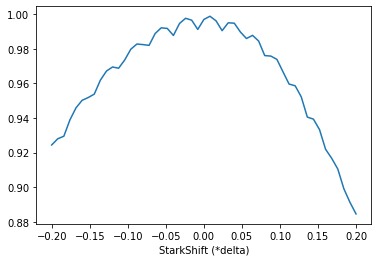

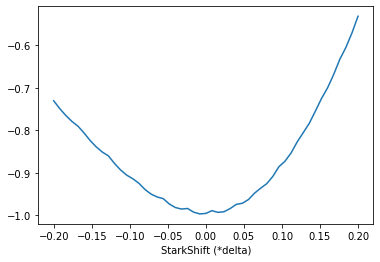

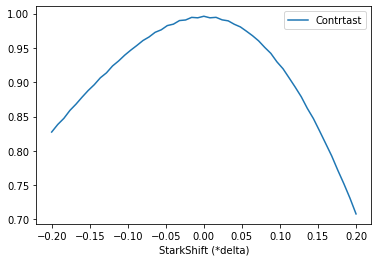

In [91]:
mins = [res[i][0] for i in range(len(res))]
maxs = [res[i][1] for i in range(len(res))]
contrast = [res[i][2] for i in range(len(res))]
plt.plot(StarkShiftList, mins, label = 'Mins')
plt.xlabel('StarkShift (*delta)')
plt.show()
plt.plot(StarkShiftList, maxs, label = 'Maxs')
plt.xlabel('StarkShift (*delta)')
plt.show()
plt.plot(StarkShiftList, contrast, label = 'Contrtast')
plt.xlabel('StarkShift (*delta)')
plt.legend()

## Power unbalance

delta =  25000.0
t_gate =  4e-05


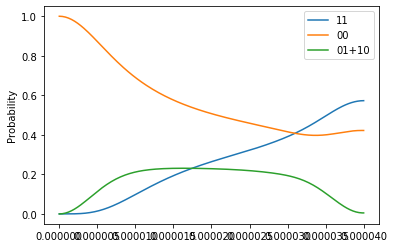

0:00:00.525514
Max parity =  0.9829992620917141
Min parity =  -0.9689035711690281
Parity contrast =  0.9759514166303711
Prob_11 =  0.5729143779718947
Prob_00 =  0.42207037823171684
Prob_01+10 =  0.005015243796387668


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.57291438+2.50389743e-17j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.38705222-2.99191216e-01j]
 [0.        +0.00000000e+00j 0.00250762+1.74652236e-18j
  0.00250762+1.53641480e-17j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.00250762-3.76793901e-17j
  0.00250762-2.35670637e-17j 0.        +0.00000000e+00j]
 [0.38705222+2.99191216e-01j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.42207038-3.20831789e-18j]]

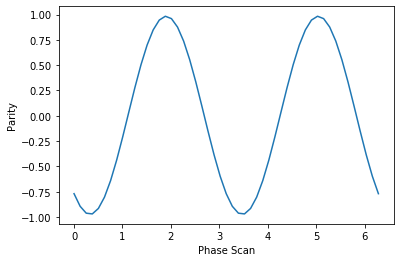

In [69]:
omega = 1.25e5
eta = 0.1
delta = 2*eta*omega
print('delta = ',delta)
tg = 1/delta
tw = 0
print('t_gate = ', tg)
exp1 = MSGateExp(Nmax=10,eta = eta)
states = exp1.time_scan(0, tg, 200, Gamma=0,
               omega_r = np.array([1.1*omega,1.1*omega]) * np.pi * 2,
               omega_b = np.array([omega,omega]) * np.pi * 2,
               delta_r = np.array([delta,delta]) * np.pi * 2,
               delta_b = np.array([-delta,-delta]) * np.pi * 2,
               phi_r = 0,
               phi_b = np.pi/4)

rho = states[-1].ptrace([0,1])
ThetaList = np.linspace(0,2*np.pi,51)
ParityScan(ThetaList, rho)
Population(states[-1])
rho

In [70]:
rho

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.57291438+2.50389743e-17j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.38705222-2.99191216e-01j]
 [0.        +0.00000000e+00j 0.00250762+1.74652236e-18j
  0.00250762+1.53641480e-17j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.00250762-3.76793901e-17j
  0.00250762-2.35670637e-17j 0.        +0.00000000e+00j]
 [0.38705222+2.99191216e-01j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.42207038-3.20831789e-18j]]

In [50]:
XX = tensor(sigmax(),sigmax())
XY = tensor(sigmax(),sigmay())
YX = tensor(sigmay(),sigmax())
YY = tensor(sigmay(),sigmay())

theta = np.pi*3/4
meas = np.cos(theta)**2*YY-np.sin(theta)*np.cos(theta)*(YX+XY)+np.sin(theta)**2*XX

print(np.real((rho*meas).tr()))
rho*meas

0.999027756971362


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[4.9904831e-01+4.65568890e-04j 0.0000000e+00+0.00000000e+00j
  0.0000000e+00+0.00000000e+00j 0.0000000e+00-4.98597471e-01j]
 [0.0000000e+00+0.00000000e+00j 4.6556889e-04+0.00000000e+00j
  4.6556889e-04+0.00000000e+00j 0.0000000e+00+0.00000000e+00j]
 [0.0000000e+00+0.00000000e+00j 4.6556889e-04+0.00000000e+00j
  4.6556889e-04+0.00000000e+00j 0.0000000e+00+0.00000000e+00j]
 [0.0000000e+00+5.00471391e-01j 0.0000000e+00+0.00000000e+00j
  0.0000000e+00+0.00000000e+00j 4.9904831e-01-4.65568890e-04j]]

In [52]:
np.sqrt(0.395**2+0.265**2)

0.4756574397610112